### Importing the required libarires

In [7]:
import torch
from datasets import load_dataset
from tqdm import tqdm
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.metrics import matthews_corrcoef
from transformers import (AdamW,T5ForConditionalGeneration,T5Tokenizer,get_linear_schedule_with_warmup)

### Loading the dataset

In [2]:
dataset = load_dataset('glue', 'qqp')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

device(type='cuda')

### Loading the tokenizer and pre-trained model

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model.to(device)

### Forming the train, validaton and test loaders¶

In [10]:
def getDataLoader(input):
    inputs = ["qqp question1: " + doc1 + " question2: " + doc2 for doc1, doc2 in zip(input['question1'], input['question2'])]
    tokenized_inputs = tokenizer(inputs, padding = True,  truncation=True, return_tensors="pt")
    source_ids = tokenized_inputs['input_ids']
    source_mask = tokenized_inputs['attention_mask']
    
    targets = ["duplicate" if label == 1 else "not_duplicate" for label in input['label']]
    tokenized_outputs = tokenizer(targets, padding = True, return_tensors="pt")
    target_ids = tokenized_outputs['input_ids']
    target_mask = tokenized_outputs['attention_mask']

    # Create a TensorDataset
    batch_size = 8
    data = TensorDataset(source_ids, source_mask, target_ids, target_mask)

    # Create a data loader
    sampler = SequentialSampler(data)
    return DataLoader(data, sampler = sampler, batch_size=batch_size)

train_dataloader = getDataLoader(dataset['train'])
validation_dataloader = getDataLoader(dataset['validation'])
test_dataloader = getDataLoader(dataset['test'])

In [11]:
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
    {
        "params": [
            p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-4,
    eps=1e-8,
)


num_epochs = 3
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

C:\Users\NIT\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Fine-tuning T5

In [12]:
from tqdm import tqdm
best_accuracy = 0
for epoch in range(num_epochs):
    model.train()
    
    total_loss = 0
    for batch in tqdm(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        source_ids, source_mask, lm_labels, target_mask = batch
        lm_labels[lm_labels[:, :] == tokenizer.pad_token_id] = -100

        optimizer.zero_grad()

        outputs = model(
            input_ids=source_ids,
            attention_mask=source_mask,
            labels = lm_labels,
            decoder_attention_mask=target_mask
        )
        
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        scheduler.step()
    
    # Compute the average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f}')
    
    
    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(validation_dataloader):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask, lm_labels, target_mask = batch
            outs = model.generate(input_ids=source_ids, 
                                  attention_mask=source_mask,
                                  max_length=3)
            predicted_labels = [tokenizer.decode(output, skip_special_tokens=True) for output in outs]
            binary_labels = [1 if label == 'duplicate' else 0 for label in predicted_labels]
            predictions.extend(binary_labels)
            
    total_correct  = 0
    for i in range(len(predictions)):
        if predictions[i]==dataset['validation'][i]['label']:
            total_correct += 1

    accuracy = total_correct/len(dataset['validation'])
    print(f'Epoch {epoch+1}/{num_epochs} - validation accuracy: {accuracy:.4f}')
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model.save_pretrained("t5-qqp")

100%|██████████████████████████████████████████████████████████████████████████| 45481/45481 [5:13:56<00:00,  2.41it/s]


Epoch 1/3 - loss: 0.0672


100%|██████████████████████████████████████████████████████████████████████████████| 5054/5054 [09:24<00:00,  8.95it/s]


Epoch 1/3 - validation accuracy: 0.8888


100%|██████████████████████████████████████████████████████████████████████████| 45481/45481 [5:16:32<00:00,  2.39it/s]


Epoch 2/3 - loss: 0.0428


100%|██████████████████████████████████████████████████████████████████████████████| 5054/5054 [09:27<00:00,  8.90it/s]


Epoch 2/3 - validation accuracy: 0.9082


100%|██████████████████████████████████████████████████████████████████████████| 45481/45481 [5:12:42<00:00,  2.42it/s]


Epoch 3/3 - loss: 0.0231


100%|██████████████████████████████████████████████████████████████████████████████| 5054/5054 [09:32<00:00,  8.82it/s]


Epoch 3/3 - validation accuracy: 0.9123


In [ ]:
fineTunedModel = T5ForConditionalGeneration.from_pretrained('t5-qqp')
fineTunedModel.cuda()

In [5]:
testDataset = dataset['test'].shuffle(seed=42)

Loading cached shuffled indices for dataset at C:\Users\NIT\.cache\huggingface\datasets\glue\qqp\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-0aa7078f1b4799e3.arrow


In [8]:
def getDataLoader2(input):
    inputs = ["qqp question1: " + doc1 + " question2: " + doc2 for doc1, doc2 in zip(input['question1'][:10000], input['question2'][:10000])]
    tokenized_inputs = tokenizer(inputs, padding = True,  truncation=True, return_tensors="pt")
    source_ids = tokenized_inputs['input_ids']
    source_mask = tokenized_inputs['attention_mask']
    
    targets = ["duplicate" if label == 1 else "not_duplicate" for label in input['label'][:10000]]
    tokenized_outputs = tokenizer(targets, padding = True, return_tensors="pt")
    target_ids = tokenized_outputs['input_ids']
    target_mask = tokenized_outputs['attention_mask']

    # Create a TensorDataset
    batch_size = 8
    data = TensorDataset(source_ids, source_mask, target_ids, target_mask)

    # Create a data loader
    sampler = SequentialSampler(data)
    return DataLoader(data, sampler = sampler, batch_size=batch_size)

test_dataloader = getDataLoader2(testDataset)

### Obtaining hidden states averaged over all the tokens to get a single representation of 768 tokens

In [9]:
def getHiddenStates(currModel, dataloader):
    currModel.eval()
    totalHiddenStates = [0]*13
    flag = True
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)
            
            source_ids, source_mask, lm_labels, target_mask = batch
            outputs = currModel(input_ids=source_ids,
                            attention_mask=source_mask,
                            labels = lm_labels,
                            decoder_attention_mask=target_mask, 
                            output_hidden_states = True, 
                            return_dict=True)

            hidden_states = outputs.encoder_hidden_states
         
            if flag == True:
                for i in range(len(hidden_states)):
                    totalHiddenStates[i] = hidden_states[i].to("cpu").mean(dim = 1)
                flag = False
            else:
                for i in range(len(hidden_states)):
                    temp = hidden_states[i].to("cpu").mean(dim = 1)
                    totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
        return totalHiddenStates   


In [10]:
hiddenStates = getHiddenStates(model, test_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_QQP.pt')
print(preTrainedHiddenStates.shape)

hiddenStates = getHiddenStates(fineTunedModel, test_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_QQP.pt')
print(fineTunedHiddenStates.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [02:50<00:00,  7.35it/s]


torch.Size([13, 10000, 768])


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [02:34<00:00,  8.11it/s]


torch.Size([13, 10000, 768])


In [11]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [12]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates[i].to(device)
        Y = fineTunedHiddenStates[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

In [13]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

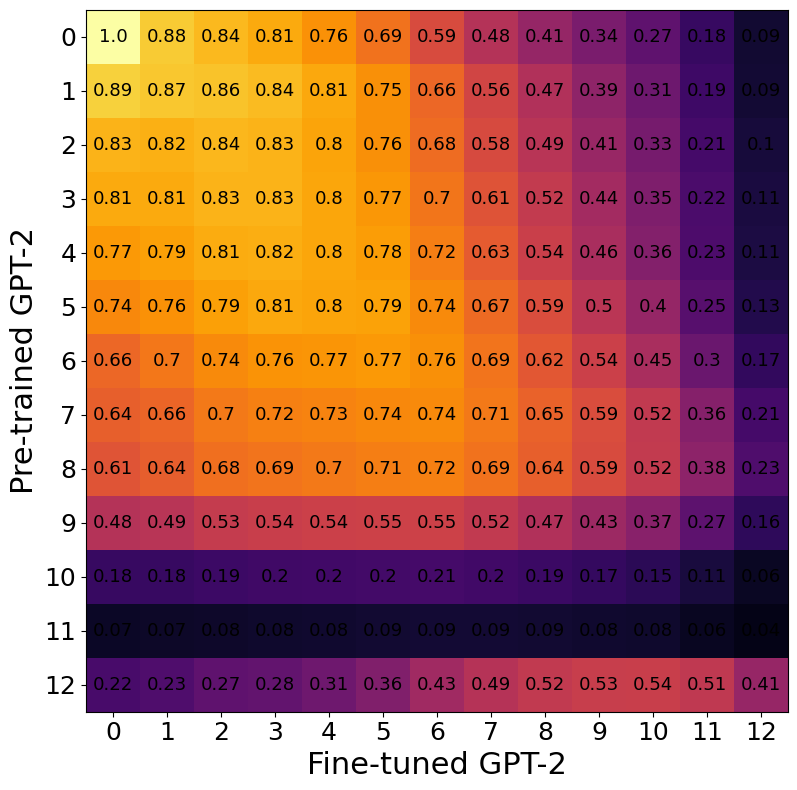

In [14]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 18)
plt.yticks(np.arange(0,13), fontsize = 18)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(cka_matrix[x][y], xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained GPT-2', fontsize = 22)
plt.xlabel('Fine-tuned GPT-2', fontsize = 22)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('QQP_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('QQP_preTrained_fineTuned.jpg',  bbox_inches='tight')

### Calculating STIR

In [15]:
preTrainedHiddenStates = torch.load('./preTrainedHiddenStates_QQP.pt').to(device)
fineTunedHiddenStates  = torch.load('./fineTunedHiddenStates_QQP.pt').to(device)
print(preTrainedHiddenStates.shape,fineTunedHiddenStates.shape)

torch.Size([13, 10000, 768]) torch.Size([13, 10000, 768])


In [16]:
distinm1 = []
distinm2 = []
for i in range(13):
    distinm1.append(torch.cdist(preTrainedHiddenStates[i], preTrainedHiddenStates[i]))
    distinm2.append(torch.cdist(fineTunedHiddenStates[i], fineTunedHiddenStates[i]))

In [17]:
for i in range(13):
    for j in range(distinm1[0].shape[0]):
        distinm1[i][j][j] = 100000.0
        distinm2[i][j][j] = 100000.0

In [18]:
num_rows = preTrainedHiddenStates.shape[1]
minDistIndForm1 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm1[i][j]))
    minDistIndForm1.append(temp)
    
minDistIndForm2 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm2[i][j]))
    minDistIndForm2.append(temp)

In [19]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [20]:
import random
def calculate(noOfSamples, noOfTimes):
    STIRm2m1 = []
    STIRm1m2 = []
    CKA = []
    for i in range(13):
        stirm2m1 = 0
        stirm1m2 = 0
        cka = 0
        for j in range(noOfTimes):
            num_list = random.sample(range(0, num_rows), noOfSamples)
            X = []
            X_ = []
            Y = []
            Y_ = []
            for k in range(len(num_list)):
                X.append(fineTunedHiddenStates[i][num_list[k]])
                X_.append(fineTunedHiddenStates[i][minDistIndForm1[i][num_list[k]]])
                Y.append(preTrainedHiddenStates[i][num_list[k]])
                Y_.append(preTrainedHiddenStates[i][minDistIndForm2[i][num_list[k]]])
                
            X = torch.stack(X, dim = 0)
            X_ = torch.stack(X_, dim = 0)
            Y = torch.stack(Y, dim = 0)
            Y_ = torch.stack(Y_, dim = 0)
            
            stirm2m1 = stirm2m1 + cuda_cka.linear_CKA(X, X_)
            stirm1m2 = stirm1m2 + cuda_cka.linear_CKA(Y, Y_)
            cka = cka + cuda_cka.linear_CKA(Y, X)
        
        STIRm2m1.append(stirm2m1/noOfTimes)
        STIRm1m2.append(stirm1m2/noOfTimes)
        CKA.append(cka/noOfTimes)
    return STIRm2m1, STIRm1m2, CKA

In [21]:
STIRm2m1, STIRm1m2, CKA = calculate(num_rows//2, 20)

STIRm2m1 = torch.stack(STIRm2m1, dim = 0)
STIRm1m2 = torch.stack(STIRm1m2,dim = 0)
CKA = torch.stack(CKA, dim = 0)

STIRm2m1 = STIRm2m1.to("cpu")
STIRm2m1 = STIRm2m1.numpy()
STIRm1m2 = STIRm1m2.to("cpu")
STIRm1m2 = STIRm1m2.numpy()
CKA = CKA .to("cpu")
CKA = CKA .numpy()

print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

STIRm2m1: [0.99552244 0.8509006  0.8240525  0.7992872  0.7541708  0.70958745
 0.67273736 0.64686966 0.6467211  0.62857705 0.6237754  0.5736681
 0.57455534]
STIRm1m2: [0.99552023 0.84618235 0.7824399  0.76557773 0.7292273  0.7083759
 0.6861163  0.67912626 0.6321535  0.4563468  0.07138319 0.01782831
 0.4236509 ]
CKA: [1.         0.87117416 0.8377959  0.82823735 0.80268735 0.7952298
 0.756841   0.707432   0.6406643  0.4270619  0.14725322 0.06274146
 0.4057214 ]


In [22]:
import numpy as np
print('STIRm2m1: ', np.round(STIRm2m1, 2))
print('STIRm1m2: ', np.round(STIRm1m2, 2))
print('CKA: ', np.round(CKA, 2))

STIRm2m1:  [1.   0.85 0.82 0.8  0.75 0.71 0.67 0.65 0.65 0.63 0.62 0.57 0.57]
STIRm1m2:  [1.   0.85 0.78 0.77 0.73 0.71 0.69 0.68 0.63 0.46 0.07 0.02 0.42]
CKA:  [1.   0.87 0.84 0.83 0.8  0.8  0.76 0.71 0.64 0.43 0.15 0.06 0.41]


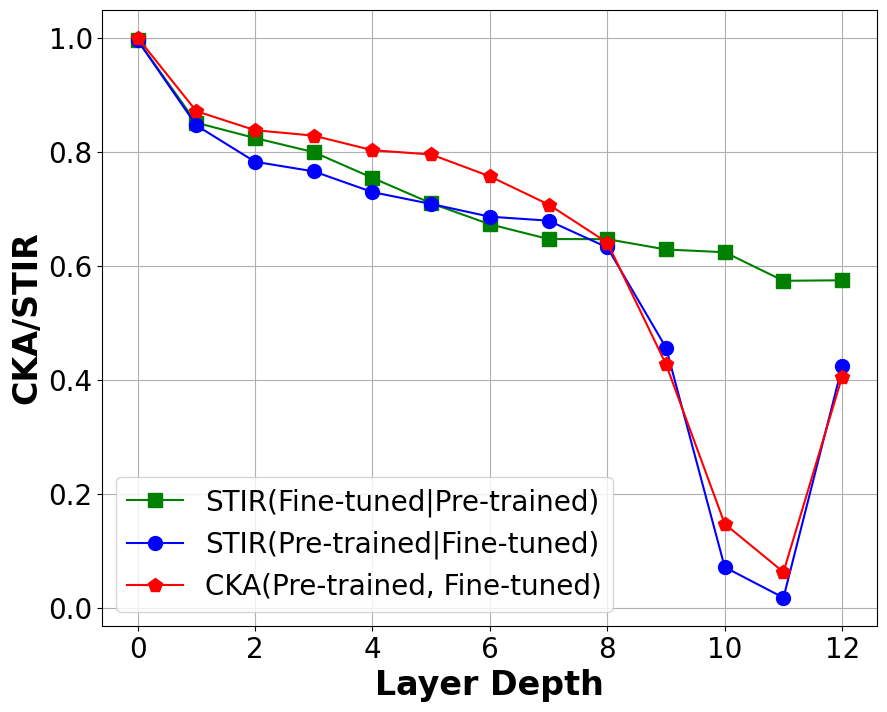

In [23]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(13)
plt.rcParams["figure.figsize"] = [10,8]

series = np.array(STIRm2m1)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='s', markersize=10, color='green')

series = np.array(STIRm1m2)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='o', markersize=10, color='blue')

series = np.array(CKA)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='p', markersize=10, color='red')

plt.legend(['STIR(Fine-tuned|Pre-trained)', 'STIR(Pre-trained|Fine-tuned)', 'CKA(Pre-trained, Fine-tuned)'], fontsize=20)
plt.xlabel('Layer Depth', fontsize = 24, fontweight = 'bold')
plt.ylabel('CKA/STIR', fontsize = 24, fontweight ='bold')

plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.tight_layout()
#plt.show()
plt.savefig('QQP CKA STIR.pdf', bbox_inches='tight')
plt.savefig('QQP CKA STIR.jpg', bbox_inches='tight')

In [28]:
import pandas as pd
def test(dataloader, device_):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask, lm_labels, target_mask = batch
            outs = model.generate(input_ids=source_ids, 
                                  attention_mask=source_mask,
                                  max_length=3)
            predicted_labels = [tokenizer.decode(output, skip_special_tokens=True) for output in outs]
            binary_labels = [1 if label == 'duplicate' else 0 for label in predicted_labels]
            predictions.extend(binary_labels)
            
    return predictions

In [29]:
predictions = test(test_dataloader, device)
filename = '../Original/QQP.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

100%|██████████████████████████████████████████████████████████████████████████| 48871/48871 [1:59:31<00:00,  6.81it/s]


In [44]:
def test2(dataloader):
    predictions = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask = batch
            outs = model.generate(input_ids=source_ids, 
                                  attention_mask=source_mask,
                                  max_length=3)
            predicted_labels = [tokenizer.decode(output, skip_special_tokens=True) for output in outs]
            binary_labels = [1 if label == 'duplicate' else 0 for label in predicted_labels]
            predictions.extend(binary_labels)
    return predictions

def getModifiedDataLoader(tq1, tq2):
    inputs = ["qqp question1: " + doc1 + " question2: "+ doc2 for doc1, doc2 in zip(tq1, tq2)]
    tokenized_inputs = tokenizer(inputs, padding = True, truncation = True, return_tensors="pt")
    source_ids = tokenized_inputs['input_ids']
    source_mask = tokenized_inputs['attention_mask']

    # Create a TensorDataset
    batch_size = 8
    data = TensorDataset(source_ids, source_mask)

    # Create a data loader
    sampler = SequentialSampler(data)
    return DataLoader(data, sampler = sampler, batch_size=batch_size)

### Text-perturbations

In [ ]:
test_question1 = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test']['question1']]
test_question2 = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test']['question2']]

In [ ]:
test_question1 = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test']['question1']]
test_question2 = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test']['question2']]

In [ ]:
import nltk
from nltk import pos_tag

def remove_nouns(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = pos_tag(words)
    filtered_sentence = [word for word, pos in tagged_words if pos != 'NN' and pos != 'NNP' and pos != 'NNS']
    return ' '.join(filtered_sentence)

test_question1 = [remove_nouns(sentence) for sentence in dataset['test']['question1']]
test_question2 = [remove_nouns(sentence) for sentence in dataset['test']['question2']]


In [ ]:
def remove_verbs(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = pos_tag(words)
    filtered_sentence = [word for word, pos in tagged_words if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
    return ' '.join(filtered_sentence)

test_question1 = [remove_verbs(sentence) for sentence in dataset['test']['question1']]
test_question2 = [remove_verbs(sentence) for sentence in dataset['test']['question2']]


In [ ]:
import nltk
import random
from nltk.tokenize import word_tokenize

def random_swap_words(sentence):
    words = word_tokenize(sentence)
    if len(words) >= 2:
        i, j = random.sample(range(len(words)), 2)
        words[i], words[j] = words[j], words[i]
        return " ".join(words)
    else:
        return sentence

test_question1 = [random_swap_words(sentence) for sentence in dataset['test']['question1']]
test_question2 = [random_swap_words(sentence) for sentence in dataset['test']['question2']]

In [ ]:
import random
from faker import Faker
from typing import List

def add_random_words(sentences: List[str]):
    fake = Faker()
    new_sentences = []
    for sentence in sentences:
        words = sentence.split()
        num_words_to_add = int(len(words) / 5)
        for i in range(num_words_to_add):
            insert_index = random.randint(0, len(words) - 1)
            words.insert(insert_index, fake.word())
        new_sentences.append(" ".join(words))
    return new_sentences

test_question1 = add_random_words(dataset['test']['question1'])
test_question2 = add_random_words(dataset['test']['question2'])

In [ ]:
import random
import string

def replace_characters(sentence, probability=0.10):
    new_sentence = ""
    for char in sentence:
        if random.random() < probability:
            char = random.choice(string.ascii_letters)
        new_sentence += char
    return new_sentence

test_question = [replace_characters(sentence) for sentence in dataset['test']['question1']]
test_question2 = [replace_characters(sentence) for sentence in dataset['test']['question2']]

In [ ]:
def changeGender(str):
    dictionary = {
    "batman": "batwoman", "batwoman": "batman",
    "boy": "girl", "girl": "boy",
    "boyfriend": "girlfriend", "girlfriend": "boyfriend",
    "father": "mother", "mother": "father",
    "husband": "wife", "wife": "husband",
    "he": "she", "she": "he", "He":"She", "She":"He",
    "his": "her", "her": "his", "His":"Her", "Her":"His",
    "male": "female", "female": "male","him":"her","her":"him",
    "man": "woman", "woman": "man",
    "Mr": "Ms", "Mr": "Ms",
    "sir": "madam", "madam": "sir",
    "son": "daughter", "daughter": "son",
    "uncle": "aunt", "aunt": "uncle",
    }

    str = str + ' ' # Append a space at the en
    temp = ""
    ans = ""

    for i in range(len(str)):
        if str[i] != ' ':
            temp += str[i]
        else:
            if temp in dictionary:
                temp = dictionary[temp]

            ans = ans + temp + ' '
            temp = ""
    return ans

test_question1 = [changeGender(sentence) for sentence in dataset['test']['question1']]
test_question2 = [changeGender(sentence) for sentence in dataset['test']['question2']]
